In [ ]:
!nvidia-smi

Sat Sep  7 11:18:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0              39W /  70W |  10537MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
%%capture
!pip install transformers==4.19.2
!pip install rouge_score

In [ ]:
from datasets import load_metric
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Code Cycle/wikiHow.csv")
df.head()

,title,heading,paragraph
0,3 Ways to Stretch the Psoas Muscle - wikiHow,Start with a halfkneeling psoas stretch,[1] Get in position for this stretch by kneeli...
1,3 Ways to Stretch the Psoas Muscle - wikiHow,Combine the psoas stretch with a quadriceps st...,Your glutes and quads help support your psoas ...
2,3 Ways to Stretch the Psoas Muscle - wikiHow,Use internal rotation to stretch the entire psoas,The simple act of internally rotating your bac...
3,3 Ways to Stretch the Psoas Muscle - wikiHow,Isolate your psoas with warrior I pose,Step up to an open doorway so that your right ...
4,3 Ways to Stretch the Psoas Muscle - wikiHow,Fully extend your psoas muscles with bridge pose,Lie on your back on the floor with your knees ...


In [ ]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)
print(df.columns)

(60234, 3)
(50204, 3)
Index(['title', ' heading', ' paragraph'], dtype='object')


In [ ]:
# Strip extra spaces from column names
df.columns = df.columns.str.strip()
print(df.columns)

Index(['title', 'heading', 'paragraph'], dtype='object')


In [ ]:
print(df.shape)
df = df.dropna()
print(df.shape)

(50204, 3)
(49567, 3)


In [ ]:
df['length'] = df.paragraph.map(lambda x: len(x.split(" ")))

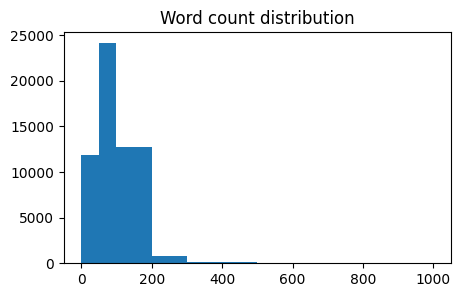

In [ ]:

numOfwords = df.length

from matplotlib import pyplot as plt

# Creating plot
fig = plt.figure(figsize=(5, 3))
plt.hist(numOfwords.to_numpy(), bins=[0, 50, 100, 200, 300, 500, 1000])

plt.title("Word count distribution")

# Show plot
plt.show()

In [ ]:
tempDf = df[df.length <= 200]
tempDf.shape

(48721, 4)

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
max_input_length = 1024
max_target_length = 64
batch_size = 16

def process_data_to_model_inputs(batch):
    # tokenize the inputs and labels
    inputs = tokenizer(
        batch["paragraph"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length,
    )

    outputs = tokenizer(
        batch["heading"],
        padding="max_length",
        truncation=True,
        max_length=max_target_length,
    )

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    # create 0 global_attention_mask lists
    batch["global_attention_mask"] = len(batch["input_ids"]) * [
        [0 for _ in range(len(batch["input_ids"][0]))]
    ]

    batch["global_attention_mask"][0][0] = 1
    batch["labels"] = outputs.input_ids

    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in labels]
        for labels in batch["labels"]
    ]

    return batch

In [ ]:
import numpy as np

train, validate, test = np.split(tempDf.sample(frac=1, random_state=42), [int(0.6 * len(df)), int(0.7 * len(df))])

print(train.shape)
print(validate.shape)
print(test.shape)

(29740, 4)
(4956, 4)
(14025, 4)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
validate = validate[:20]
validate.shape

(20, 4)

In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(validate)

In [ ]:
train_dataset = train_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["title", "heading", "paragraph", "length", "__index_level_0__"],
)

Map:   0%|          | 0/29740 [00:00<?, ? examples/s]

In [ ]:
val_dataset = val_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["title", "heading", "paragraph", "length", "__index_level_0__"],

)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [ ]:
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)

val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],

)

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments
import transformers
from datasets import load_metric

# Load the model
led = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)

# Model configuration
led.config.num_beams = 2
led.config.max_length = 64
led.config.min_length = 2
led.config.length_penalty = 2.0
led.config.early_stopping = True
led.config.no_repeat_ngram_size = 3

# Load ROUGE metric
rouge = load_metric("rouge")

# Define metric computation function
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # Decode predictions and labels
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id  # Mask out ignored labels
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    # Compute ROUGE
    rouge_output = rouge.compute(
        predictions=pred_str,
        references=label_str,
        rouge_types=["rouge2"]
    )["rouge2"].mid

    # Return precision, recall, and f-measure
    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

# Set logging verbosity
transformers.logging.set_verbosity_info()

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    output_dir="./",
    logging_steps=5,
    eval_steps=10,
    save_steps=10,
    save_total_limit=2,
    gradient_accumulation_steps=4,
    num_train_epochs=10
)


Downloading:   0%|          | 0.00/618M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:392: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Seq2SeqTrainer(
  model= led,
  tokenizer=tokenizer,
  args=training_args,
  compute_metrics =compute_metrics,
  train_dataset=train_dataset,
  eval_dataset=val_dataset,
)

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 29740
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 4640


Step,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
10,2.300200,2.550782,0.150000,0.129400,0.137700
20,2.399800,2.536983,0.101300,0.075400,0.084300
30,2.339600,2.528645,0.114300,0.089700,0.098600
40,2.253000,2.511994,0.162500,0.136500,0.146000
50,2.438900,2.546745,0.193300,0.145200,0.159700
60,2.259200,2.474265,0.136700,0.092500,0.105200
70,2.235800,2.451918,0.125400,0.117500,0.117400
80,2.254800,2.435832,0.102400,0.088100,0.093100
90,2.282000,2.467951,0.066800,0.053200,0.058800


***** Running Evaluation *****
  Num examples = 20
  Batch size = 16
Saving model checkpoint to ./checkpoint-10
Configuration saved in ./checkpoint-10/config.json
Model weights saved in ./checkpoint-10/pytorch_model.bin
tokenizer config file saved in ./checkpoint-10/tokenizer_config.json
Special tokens file saved in ./checkpoint-10/special_tokens_map.json
Deleting older checkpoint [checkpoint-30] due to args.save_total_limit
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.a

KeyboardInterrupt: 

In [ ]:
import pandas as pd
from datasets import Dataset


sample_paragraph = [
    "The reason why I loved the top-down culture at Apple is that important decisions are taken faster. Having an expert giving you green light or not keeps the momentum. How many times in a bottom-up culture do we spend weeks and weeks, sometimes even months, trying to get alignment with +10 people, because every single person needs to agree with the point of view? It is exhausting. So again, my experience is that having that one leader to look up to to help guide decisions is time-saving, it helps us focus on the design craft, instead of project management."
]
df = pd.DataFrame(sample_paragraph, columns=['paragraph'])

print(df['paragraph'][0])
df_test = Dataset.from_pandas(df)
print(df_test)

The reason why I loved the top-down culture at Apple is that important decisions are taken faster. Having an expert giving you green light or not keeps the momentum. How many times in a bottom-up culture do we spend weeks and weeks, sometimes even months, trying to get alignment with +10 people, because every single person needs to agree with the point of view? It is exhausting. So again, my experience is that having that one leader to look up to to help guide decisions is time-saving, it helps us focus on the design craft, instead of project management.
Dataset({
    features: ['paragraph'],
    num_rows: 1
})


In [ ]:
from datasets import load_metric, load_dataset
import torch
from transformers import LEDTokenizer, LEDForConditionalGeneration

# Load tokenizer and model
tokenizer = LEDTokenizer.from_pretrained("/content/checkpoint-90")
model = LEDForConditionalGeneration.from_pretrained("/content/checkpoint-90").to("cuda").half()

def generate_answer(batch):
    # Tokenize inputs
    inputs_dict = tokenizer(
        batch["paragraph"],
        padding="max_length",
        max_length=512,
        return_tensors="pt",
        truncation=True
    )

    input_ids = inputs_dict.input_ids.to("cuda")
    attention_mask = inputs_dict.attention_mask.to("cuda")
    global_attention_mask = torch.zeros_like(attention_mask)

    # Apply global attention mask
    # global_attention_mask[:, 0] = 1  # Uncomment this line if global attention is needed

    # Generate predictions
    predicted_abstract_ids = model.generate(
        input_ids,
        attention_mask=attention_mask,
        global_attention_mask=global_attention_mask
    )

    # Decode generated IDs
    batch["generated_heading"] = tokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)

    return batch

# Assuming df_test is defined and is a Dataset
result = df_test.map(generate_answer, batched=True, batch_size=2)

Didn't find file /content/checkpoint-90/added_tokens.json. We won't load it.
loading file /content/checkpoint-90/vocab.json
loading file /content/checkpoint-90/merges.txt
loading file None
loading file /content/checkpoint-90/special_tokens_map.json
loading file /content/checkpoint-90/tokenizer_config.json
loading configuration file /content/checkpoint-90/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Input ids are automatically padded from 512 to 1024 to be a multiple of `config.attention_window`: 1024


In [ ]:
result["generated_heading"]

['Have a leader to guide you through the process']

In [ ]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import string
from transformers import LEDTokenizer, LEDForConditionalGeneration
import torch

# Load English tokenizer, POS tagger, and NER from spaCy
nlp = spacy.load("en_core_web_sm")

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load the previously trained model and tokenizer
tokenizer = LEDTokenizer.from_pretrained("/content/checkpoint-90")
model = LEDForConditionalGeneration.from_pretrained("/content/checkpoint-90").to("cuda").half()

def preprocess_text(text):
    # Preprocess text: remove punctuation and stop words
    text = text.lower()
    text = "".join([char for char in text if char not in string.punctuation])
    tokens = [word for word in text.split() if word not in stop_words]
    return " ".join(tokens)

def extract_tags(paragraph, method="tfidf", top_n=5):
    """
    Generalized tag extraction function using different NLP methods.

    Args:
        paragraph (str): Input paragraph.
        method (str): The method to use for tag extraction. Options are "tfidf" and "ner".
        top_n (int): Number of tags to extract.

    Returns:
        List[str]: Extracted tags.
    """
    paragraph_clean = preprocess_text(paragraph)

    if method == "tfidf":
        # Use TF-IDF to extract important words
        vectorizer = TfidfVectorizer(max_features=top_n)
        tfidf_matrix = vectorizer.fit_transform([paragraph_clean])
        feature_names = vectorizer.get_feature_names_out()
        return list(feature_names)

    elif method == "ner":
        # Use Named Entity Recognition (NER) from spaCy
        doc = nlp(paragraph)
        tags = [ent.text for ent in doc.ents]
        return tags[:top_n]

    else:
        raise ValueError("Invalid method. Choose either 'tfidf' or 'ner'.")

def generate_output(batch, tag_method="tfidf", top_n=5):
    # Tokenize the input paragraph
    inputs_dict = tokenizer(batch["paragraph"], padding="max_length", max_length=512, return_tensors="pt", truncation=True)
    input_ids = inputs_dict.input_ids.to("cuda")
    attention_mask = inputs_dict.attention_mask.to("cuda")
    global_attention_mask = torch.zeros_like(attention_mask)

    # Generate heading
    predicted_heading_ids = model.generate(input_ids, attention_mask=attention_mask, global_attention_mask=global_attention_mask)
    heading = tokenizer.batch_decode(predicted_heading_ids, skip_special_tokens=True)[0]

    # Generate summary
    summary_ids = model.generate(input_ids, attention_mask=attention_mask, global_attention_mask=global_attention_mask, max_length=150, num_beams=4)
    summary = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)[0]

    # Generate tags
    paragraph_text = batch["paragraph"][0]
    tags = extract_tags(paragraph_text, method=tag_method, top_n=top_n)

    # Return only the generated content
    return {
        "Heading": heading,
        "Summary": summary,
        "Tags": tags
    }

# Sample data
batch = {
    "paragraph": [
        "Coffee, a dark, aromatic beverage derived from roasted coffee beans, has captivated the world for centuries. Its rich history, complex flavors, and cultural significance have made it a beloved staple in countless societies. Coffee's appeal lies not only in its taste but also in its stimulating effects. The caffeine content in coffee can increase alertness, improve mood, and enhance cognitive function. However, excessive caffeine consumption can lead to side effects like anxiety, insomnia, and digestive problems."
    ]
}

# Generate output
result = generate_output(batch, tag_method="tfidf", top_n=5)

# Print the formatted output
print(f"Heading: {result['Heading']}")
print(f"Summary: {result['Summary']}")
print(f"Tags: {', '.join(result['Tags'])}")


Didn't find file /content/checkpoint-90/added_tokens.json. We won't load it.
loading file /content/checkpoint-90/vocab.json
loading file /content/checkpoint-90/merges.txt
loading file None
loading file /content/checkpoint-90/special_tokens_map.json
loading file /content/checkpoint-90/tokenizer_config.json
loading configuration file /content/checkpoint-90/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder

{'Heading': 'Caffeine is a stimulant', 'Summary': 'Add coffee to your diet', 'Tags': ['coffee', 'caffeine', 'alertness', 'anxiety', 'cognitive function']}


In [ ]:
print("Heading", result['Heading'])

Heading Caffeine is a stimulant


In [ ]:
print("Heading", result['Summary'])

Heading Add coffee to your diet


In [ ]:
print("Heading", result['Tags'])

Heading ['coffee', 'caffeine', 'alertness', 'anxiety', 'cognitive function']
